# Deadlines

In [2]:
import pandas as pd

In [3]:
import utils.checker as check
import utils.presenter as show
import utils.schedule_interarrival as sit
import utils.schedule_solver__with_arrivals as ssv

In [4]:
# Datei laden
with open("data/jobshop_instances.json", "r", encoding="utf-8") as f:
    jobshop_instances = json.load(f)

instance =  jobshop_instances["instance ft10"]
show.print_jobs(instance)

job 0:  [[0, 29], [1, 78], [2, 9], [3, 36], [4, 49], [5, 11], [6, 62], [7, 56], [8, 44], [9, 21]]
job 1:  [[0, 43], [2, 90], [4, 75], [9, 11], [3, 69], [1, 28], [6, 46], [5, 46], [7, 72], [8, 30]]
job 2:  [[1, 91], [0, 85], [3, 39], [2, 74], [8, 90], [5, 10], [7, 12], [6, 89], [9, 45], [4, 33]]
job 3:  [[1, 81], [2, 95], [0, 71], [4, 99], [6, 9], [8, 52], [7, 85], [3, 98], [9, 22], [5, 43]]
job 4:  [[2, 14], [0, 6], [1, 22], [5, 61], [3, 26], [4, 69], [8, 21], [7, 49], [9, 72], [6, 53]]
job 5:  [[2, 84], [1, 2], [5, 52], [3, 95], [8, 48], [9, 72], [0, 47], [6, 65], [4, 6], [7, 25]]
job 6:  [[1, 46], [0, 37], [3, 61], [2, 13], [6, 32], [5, 21], [9, 32], [8, 89], [7, 30], [4, 55]]
job 7:  [[2, 31], [0, 86], [1, 46], [5, 74], [4, 32], [6, 88], [8, 19], [9, 48], [7, 36], [3, 79]]
job 8:  [[0, 76], [1, 69], [3, 76], [5, 51], [2, 85], [9, 11], [6, 40], [7, 89], [4, 26], [8, 74]]
job 9:  [[1, 85], [0, 13], [2, 61], [6, 7], [8, 64], [9, 76], [5, 47], [3, 52], [4, 90], [7, 45]]



### a) Ankunftszeiten

In [6]:
mean_interarrival_time = sit.calculate_mean_interarrival_time(instance)
mean_interarrival_time

70.11

In [7]:
df_arrivals = sit.generate_job_arrivals_df_by_mean_interarrival_time(instance, t_a=mean_interarrival_time)
df_arrivals

,Job,Arrival
0,job 0,0.00
1,job 1,84.93
2,job 2,106.18
3,job 3,148.31
4,job 4,185.08
5,job 5,251.37
6,job 6,312.71
7,job 7,329.63
8,job 8,344.30
9,job 9,429.20


### b) Schedule

In [9]:
df_fcfs = ssv.schedule_fcfs_with_arrivals(instance, df_arrivals)
df_fcfs

,Job,Arrival,Machine,Start,Processing Time,End
0,job 0,0.0,M0,0.0,29,29.0
1,job 0,0.0,M1,29.0,78,107.0
3,job 0,0.0,M2,107.0,9,116.0
5,job 0,0.0,M3,116.0,36,152.0
7,job 0,0.0,M4,152.0,49,201.0
...,...,...,...,...,...,...
91,job 9,429.2,M9,1040.0,76,1116.0
96,job 9,429.2,M5,1116.0,47,1163.0
97,job 9,429.2,M3,1173.0,52,1225.0
98,job 9,429.2,M4,1225.0,90,1315.0


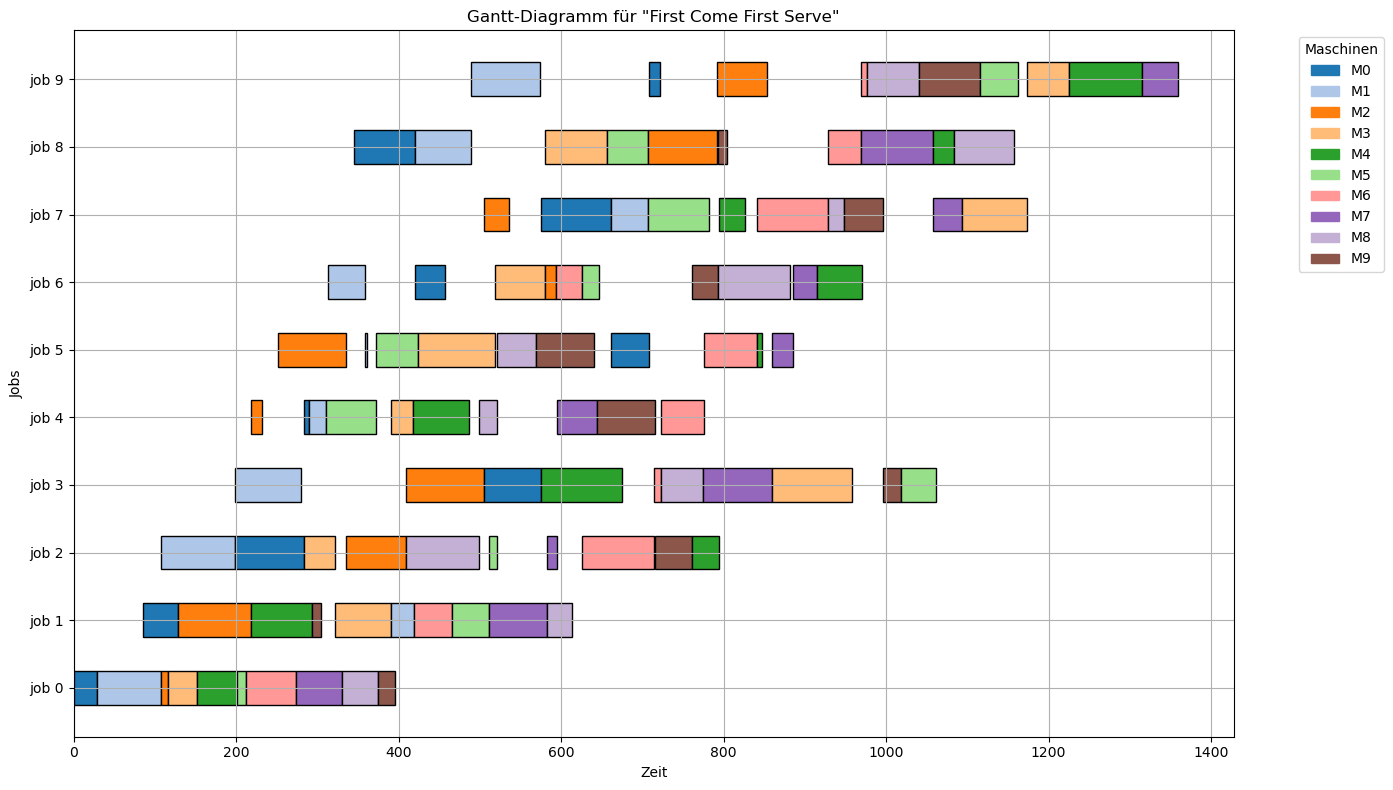

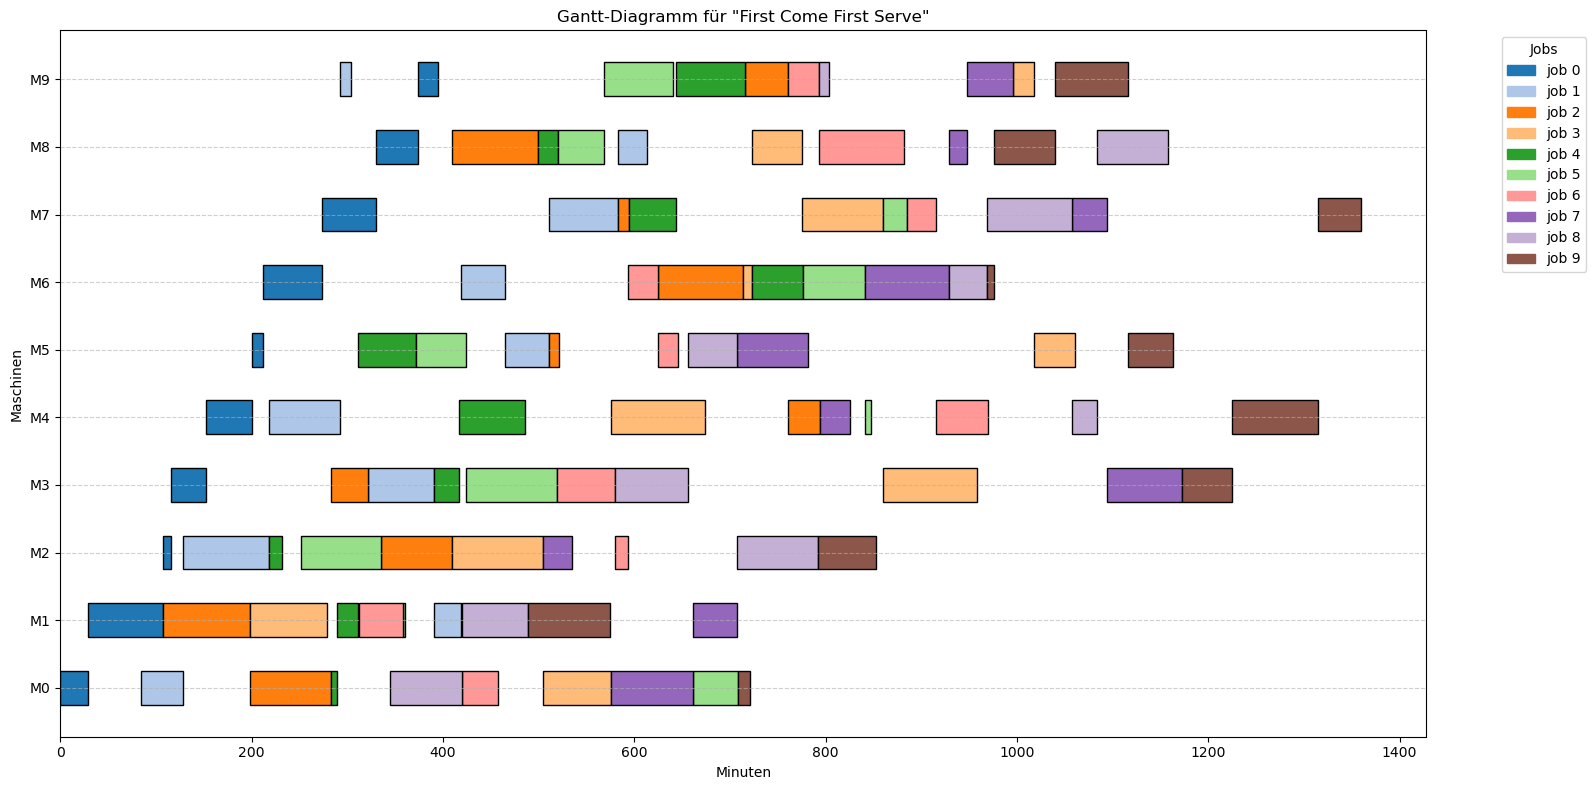

✅ Keine Maschinenkonflikte gefunden
✅ Job-Machinen-Reihenfolge (Reihenfolge der Operationen je Job) ist korrekt!
✅ Alle Operation starten erst nach Arrival des Job
✅ Zeitliche technologische Reihenfolge korrekt.

✅ Alle Constraints wurden erfüllt.



True

In [10]:
category = "First Come First Serve"

show.plot_gantt_jobs(df_fcfs, 'Gantt-Diagramm für "{}"'.format(category), duration_column= "Processing Time")
show.plot_gantt_machines(df_fcfs, 'Gantt-Diagramm für "{}"'.format(category), duration_column= "Processing Time")

check.check_all_constraints(df_fcfs, instance)

## Deadlines

$$
{d_{j}=a_{j}+k\,p_{j}}
$$  

$$
S(k)=\frac{1}{n}\sum_{j=1}^{n}\mathbf{1}\!\bigl[C_{j}(k)\le d_{j}(k)\bigr]
$$  

$$
S(k)\;\ge\;S_{\text{target}}
$$  

---

* **$a_{j}$** – Ankunftszeit (Release-Date) von Job $j$  
* **$p_{j}$** – *Processing time* des Jobs (aus dem Job Shop Scheduling-Problem) 

  $$p_{j}=\sum_{(m,d)\in j} d$$  

  Summe aller Operationsdauern $d$ von Job $j$ über sämtliche Maschinen $m$.  
* **$k$** – Due-Date-Faktor, den die Binärsuche einstellt  
* **$d_{j}$** – zugewiesene Deadline für Job $j$  
* **$C_{j}(k)$** – Fertigstellzeit von Job $j$ im geplanten Schedule bei Faktor $k$  
* **$\mathbf{1}[\;\cdot\;]$** – Indikatorfunktion (1, wenn Aussage wahr; sonst 0)  
* **$S(k)$** – gemessener Service-Level (Anteil pünktlicher Jobs) bei Faktor $k$  
* **$S_{\text{target}}$** – gewünschter Mindest-Service-Level (z. B. $0{,}95$ - mindestens $95$% aller **Jobs** sollen ihre **Deadline** einhalten)  


In [13]:
def calc_due_dates(jobs: dict, arrivals: pd.DataFrame, k: float) -> dict:
    """gibt Dict {job_id: d_j} für gegebenes k zurück"""
    p_tot = {j: sum(d for _, d in ops) for j, ops in jobs.items()}
    a = arrivals.set_index("Job")["Arrival"].to_dict()
    return {j: a[j] + k * p_tot[j] for j in jobs}


def find_k(jobs, arrivals, schedule_func, target_service=0.95):
    """sucht k via Binärsuche; Schedule einmal vorterminiert"""
    
    # 1) einmaligen Schedule holen (für z.B. FCFS o.ä., der nicht deadline‐abhängig ist)
    sched = schedule_func(jobs, arrivals)
    
    # 2) Binärsuche
    lo, hi = 0.5, 5.0                      # Startintervall (evtl. anpassen)
    for _ in range(15):                    # 15 Iterationen ≈ 1/2^15 Genauigkeit            
        k = (lo + hi) / 2
        d = calc_due_dates(jobs, arrivals, k)
        
        # Service‐Level neu berechnen
        on_time = (sched["End"] <= sched["Job"].map(d)).mean()
        if on_time >= target_service:
            hi = k                          # Deadlines sind noch zu großzügig
        else:
            lo = k                          # Deadlines zu eng
    return k, calc_due_dates(jobs, arrivals, k)


In [14]:
k_opt, deadlines = find_k(instance, df_arrivals, ssv.schedule_fcfs_with_arrivals)
print(f"Gefundener Due-Date-Faktor k = {k_opt:.4f}")

Gefundener Due-Date-Faktor k = 1.4738


In [15]:
df_arrivals_deadlines = df_arrivals.assign(Deadline=df_arrivals["Job"].map(deadlines)).sort_values("Arrival")
df_arrivals_deadlines

,Job,Arrival,Deadline
0,job 0,0.00,582.151260
1,job 1,84.93,836.568336
2,job 2,106.18,943.298774
3,job 3,148.31,1113.649432
4,job 4,185.08,764.283659
5,job 5,251.37,982.375127
6,job 6,312.71,925.811074
7,job 7,329.63,1124.008555
8,job 8,344.30,1224.158994
9,job 9,429.20,1225.052356


In [16]:
df_temp= df_fcfs.groupby('Job', as_index=False).agg(End=('End', 'max'))

df_arrivals_deadlines.merge(df_temp, on="Job").sort_values("Arrival")[["Job","Arrival", "End", "Deadline"]]

,Job,Arrival,End,Deadline
0,job 0,0.00,395.0,582.151260
1,job 1,84.93,613.0,836.568336
2,job 2,106.18,794.0,943.298774
3,job 3,148.31,1061.0,1113.649432
4,job 4,185.08,776.0,764.283659
5,job 5,251.37,885.0,982.375127
6,job 6,312.71,970.0,925.811074
7,job 7,329.63,1173.0,1124.008555
8,job 8,344.30,1158.0,1224.158994
9,job 9,429.20,1360.0,1225.052356
